<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Remote%20Sensing/image_classification__dnn_h2o_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network - Supervised Image Classification in H20 R

Zia Ahmed, University at Buffalo

H2O’s Deep Learning is based on a multi-layer feedforward artificial neural netmax-outained with stochastic gradient descent using a bacmanye network. It can contain many hidden layers consisting of neurons with tanh, rectifier, and max out activation functions. Advanced features such as adaptive learning rate, rate annealing, momentum training, dropout, L1 or L2 regularization, checkpointing, and grid search enable high predictive accuracy. Each compute node trains a copy of the global model parameters on its local data with multi-threading (asynchronously) and contributes periodically to the global model via model averaging across the network.

H2O is a powerful, open-source platform that lets you build machine learning models and predictive analytics on big data. It's written in Java and can read data from a distributed and local cluster. You can access H2O's capabilities from any external program or script using JSON over HTTP. H2O's web interface, R binding, and Python binding all use the Rest API.



### Insatll rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314928 sha256=d50d5624085abffe2a32fe42de8431670c29473eae5279155ca80b22661c1cc5
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')


#### Install h2o

In [ ]:
%%R
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages(lib='drive/My Drive/R/')))) { install.packages(pkg) }
}
install.packages("h2o", type="source",lib='drive/My Drive/R/', repos="https://h2o-release.s3.amazonaws.com/h2o/rel-3.42.0/2/R")

### Load Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (terra)
library (tidyterra)
library(tidymodels)
library(sf)
library(raster)
library(tidyverse)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(data.table)

### Data

In this lesson, we will use a sub-set of Landsat 9 satellite covering the central part of the country. We have already prepared this data and created two dataframe (point_data and prediction grid data) and we  will use them for pixel-based classification using h2o-DNN model in R.

1. Training Data: AOI-1
2. Test Data: AO1-2
3. Pprediction grid: AO1 and AOI 2

The data can be found [here](https://github.com/zia207/r-colab/tree/main/Data/DSM_AOI/Landsat_Subset/AOI_1).

We will train the DNN model with five feature classes extracted from Google Earth imagery: (1) home stage vegetation, (2) cropland, (3) Bare soil/Developed, and (4) water bodies, (5) wet-fallow. Detail was described in previous [section](https://github.com/zia207/r-colab/blob/main/NoteBook/Remote%20Sensing/training_data_processing_classification.ipynb).



In [4]:
%%R
# training data
point<-fread("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/point_data.csv")
point.df<-point[,3:10] %>%
glimpse()

Rows: 245,459
Columns: 8
$ B2       <int> 9169, 9169, 9169, 9169, 9119, 9119, 9119, 9108, 9108, 9108, 9…
$ B3       <int> 10301, 10301, 10301, 10301, 10279, 10279, 10279, 10298, 10298…
$ B4       <int> 9516, 9516, 9516, 9516, 9490, 9490, 9490, 9545, 9545, 9545, 9…
$ B5       <int> 9919, 9919, 9919, 9919, 9919, 9919, 9919, 9939, 9939, 9939, 9…
$ B6       <int> 8417, 8417, 8417, 8417, 8409, 8409, 8409, 8418, 8418, 8418, 8…
$ B7       <int> 7970, 7970, 7970, 7970, 7962, 7962, 7962, 7963, 7963, 7963, 7…
$ dem      <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ Class_ID <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…


In [ ]:
%%R
# prediction grid
# AOI-1
grid_01<-fread("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/prediction_grid_data_01.csv")
# AOI-2
grid_02<-fread("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/prediction_grid_data_02.csv") %>%
glimpse()

In [6]:
%%R
# grid features
grid.df_01<-grid_01[,4:10]
grid.df_02<-grid_02[,4:10] %>%
glimpse()

Rows: 1,000,000
Columns: 7
$ B2  <int> 8459, 8440, 8405, 8453, 8461, 8424, 8433, 8435, 8452, 8545, 8473, …
$ B3  <int> 10037, 9984, 9943, 9972, 10052, 10075, 10089, 10023, 10048, 10150,…
$ B4  <int> 9552, 9508, 9478, 9517, 9515, 9507, 9516, 9414, 9496, 9703, 9592, …
$ B5  <int> 10785, 10670, 10395, 11683, 11521, 10427, 10604, 10920, 10728, 104…
$ B6  <int> 8723, 8742, 8476, 9858, 9530, 8649, 8902, 9204, 9069, 8501, 8852, …
$ B7  <int> 8083, 8139, 7983, 8874, 8642, 8078, 8300, 8477, 8418, 8010, 8214, …
$ dem <dbl> 4.824776, 5.421584, 4.683115, 4.545923, 5.788843, 6.390258, 6.0717…


In [7]:
%%R
# grid prediction locations
grid.xy_01<-grid_01[,1:2]
grid.xy_02<-grid_02[,1:2] %>%
 glimpse()

Rows: 1,000,000
Columns: 2
$ x <int> 150930, 150960, 150990, 151020, 151050, 151080, 151110, 151140, 1511…
$ y <int> 2558550, 2558550, 2558550, 2558550, 2558550, 2558550, 2558550, 25585…


In [11]:
%%R
# test data: AOI-2
point_02<-fread("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/point_data_test_aoi_2.csv")
test.df_02<-point_02[,3:10] %>%
glimpse()

Rows: 42,847
Columns: 8
$ B2       <int> 9523, 9523, 9523, 9492, 9492, 9492, 9558, 9558, 9558, 9580, 9…
$ B3       <int> 10909, 10909, 10909, 10905, 10905, 10905, 10933, 10933, 10933…
$ B4       <int> 10741, 10741, 10741, 10701, 10701, 10701, 10695, 10695, 10695…
$ B5       <int> 10114, 10114, 10114, 10037, 10037, 10037, 9947, 9947, 9947, 9…
$ B6       <int> 8206, 8206, 8206, 8182, 8182, 8182, 8181, 8181, 8181, 8196, 8…
$ B7       <int> 7799, 7799, 7799, 7796, 7796, 7796, 7802, 7802, 7802, 7799, 7…
$ dem      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ Class_ID <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…


### Import h2o

In [ ]:
%%R
.libPaths('drive/My Drive/R')
library(h2o)
h2o.init()
#disable progress bar
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()

### Import data to h2o cluster

In [12]:
%%R
df<-  as.h2o(point.df)
grid_01<- as.h2o(grid.df_01)
grid_02<- as.h2o(grid.df_02)
test_02<- as.h2o(test.df_02)


### Split data

In [13]:
%%R
df$Class_ID= as.factor(df$Class_ID)
splits <- h2o.splitFrame(df, c(0.75,0.125), seed=1234)
train  <- h2o.assign(splits[[1]], "train.hex") # 75%
valid  <- h2o.assign(splits[[2]], "valid.hex") # 12%
test   <- h2o.assign(splits[[3]], "test.hex")  # 13%

#### Define response and predictors

In [14]:
%%R
response <- "Class_ID"
predictors <- setdiff(names(df), response)
predictors

[1] "B2"  "B3"  "B4"  "B5"  "B6"  "B7"  "dem"


## Fit DNN model

We will fit DNN model with following parameters:

standardize: logical. If enabled, automatically standardize the data.

distribution:

activation: Specify the activation function. One of:

  - tanh
  
  - tanh_with_dropout
  
  - rectifier (default)
  
  - rectifier_with_dropout

  - maxout (not supported when autoencoder is enabled)
  
  - maxout_with_dropout
  
hidden: Specify the hidden layer sizes (e.g., (100,100)). The value must be positive. This option defaults to (200,200).

adaptive_rate: Specify whether to enable the adaptive learning rate (ADADELTA). This option defaults to True (enabled).

epochs: Specify the number of times to iterate (stream) the dataset. The value can be a fraction. This option defaults to 10.

epsilon: (Applicable only if adaptive_rate=True) Specify the adaptive learning rate time smoothing factor to avoid dividing by zero. This option defaults to 1e-08.

input_dropout_ratio: Specify the input layer dropout ratio to improve generalization. Suggested values are 0.1 or 0.2. This option defaults to 0.

l1: Specify the L1 regularization to add stability and improve generalization; sets the value of many weights to 0 (default).

l2: Specify the L2 regularization to add stability and improve generalization; sets the value of many weights to smaller values. Defaults to 0.

max_w2: Specify the constraint for the squared sum of the incoming weights per unit (e.g. for rectifier). Defaults to 3.4028235e+38.

momentum_start: (Applicable only if adaptive_rate=False) Specify the initial momentum at the beginning of training; we suggest 0.5. This option defaults to 0.

rate: (Applicable only if adaptive_rate=False) Specify the learning rate. Higher values result in a less stable model, while lower values lead to slower convergence. This option defaults to 0.005.

rate_annealing: Learning rate decay, (Applicable only if adaptive_rate=False) Specify the rate annealing value. rate(1+ rate_annealing × samples), This option defaults to 1e-06.

rate_decay: (Applicable only if adaptive_rate=False) Specify the rate decay factor between layers. N-th layer: rate × rate_decay(n−1). This options defaults to 1.

rho: (Applicable only if adaptive_rate is enabled) Specify the adaptive learning rate time decay factor. This option defaults to 0.99.

shuffle_training_data: Specify whether to shuffle the training data. This option is recommended if the training data is replicated and the value of train_samples_per_iteration is close to the number of nodes times the number of rows. This option defaults to False (disabled).

stopping_tolerance = Relative tolerance for metric-based stopping criterion

stopping_rounds = Early stopping based on convergence of stopping_metric.Defaults to 5.

stopping_metric = Metric to use for early stopping

variable_importances: Specify whether to compute variable importance. This option defaults to True (enabled).

In [15]:
%%R
dnn_model <- h2o.deeplearning(
                       model_id="DNN_model_ID",
                       training_frame= train,
                       validation_frame= valid,
                       x=predictors,
                       y=response,
                       distribution ="AUTO",
                       standardize = TRUE,
                       shuffle_training_data = TRUE,
                       activation = "Rectifier",
                       hidden = c(128, 128, 128),
                       epochs = 100,
                       adaptive_rate = TRUE,
                       rate = 0.001,
                       rate_annealing = 1e-06,
                       rate_decay = 1,
                       rho = 0.99,
                       epsilon = 1e-08,
                       momentum_start = 0.2,
                       momentum_stable =0.6,
                       input_dropout_ratio = 0.0001,
                       l1 = 0.0005,
                       l2 = 0.0001,
                       max_w2 = 3.4028235e+38,
                       stopping_tolerance = 0.001,
                       stopping_rounds = 2,
                       stopping_metric = "logloss",
                       nfolds = 5,
                       keep_cross_validation_models = TRUE,
                       keep_cross_validation_predictions = TRUE,
                       variable_importances = TRUE,
                       seed=1256
                       )

### The Model Summary

In [16]:
%%R
summary(dnn_model)

Model Details:

H2OMultinomialModel: deeplearning
Model Key:  DNN_model_ID 
Status of Neuron Layers: predicting Class_ID, 5-class classification, multinomial distribution, CrossEntropy loss, 34,693 weights/biases, 416.0 KB, 1,494,814 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1     7     Input  0.01 %       NA       NA        NA       NA       NA
2     2   128 Rectifier  0.00 % 0.000500 0.000100  0.018961 0.018180 0.000000
3     3   128 Rectifier  0.00 % 0.000500 0.000100  0.264334 0.170630 0.000000
4     4   128 Rectifier  0.00 % 0.000500 0.000100  0.193853 0.174127 0.000000
5     5     5   Softmax      NA 0.000500 0.000100  0.383439 0.276899 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2   -0.002367   0.117532  0.045826 0.124766
3   -0.001723   0.048621  0.013681 0.105050
4   -0.000377   0.051554  0.042043 0.221737
5   -0.045468   0.348718 -0.004216 0.00613

In [17]:
%%R
h2o.mean_per_class_error(dnn_model, train = TRUE, valid = TRUE, xval = TRUE)

    train     valid      xval 
0.1395742 0.1517461 0.1412872 


### Soring

In [ ]:
%%R
scoring_history<-dnn_model@model$scoring_history
scoring_history

### Plot the classification error

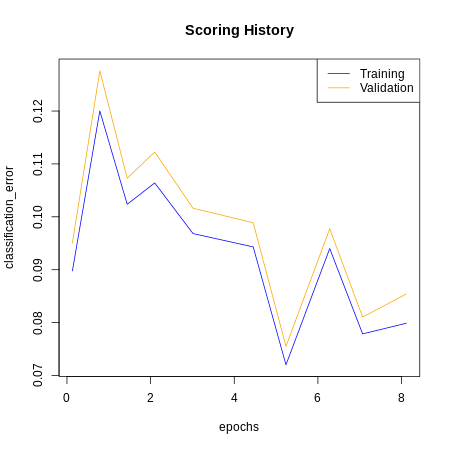

In [19]:
%%R -w 450 -h 450 -u px
plot(dnn_model,
     timestep = "epochs",
     metric = "classification_error")

### Confusion matrix

In [20]:
%%R
# training
train.cf<-h2o.confusionMatrix(dnn_model)
print(train.cf)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
          0    1   2    3   4  Error          Rate
0      1738  359  44    3   1 0.1897 = 407 / 2,145
1        16 5189  18   11   5 0.0095 =  50 / 5,239
2         9   73 556    1   0 0.1299 =    83 / 639
3         2   51   2 1246  16 0.0539 =  71 / 1,317
4         0   58   1  122 394 0.3148 =   181 / 575
Totals 1765 5730 621 1383 416 0.0799 = 792 / 9,915


In [21]:
%%R
# validation
valid.cf<-h2o.confusionMatrix(dnn_model,valid=TRUE)
print(valid.cf)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
          0     1    2    3    4  Error             Rate
0      5299  1079  114   10    6 0.1858 =  1,209 / 6,508
1        45 15822   81   19   17 0.0101 =   162 / 15,984
2        33   273 1749    5    1 0.1514 =    312 / 2,061
3        14   225    3 3832   31 0.0665 =    273 / 4,105
4         0   189    0  465 1242 0.3449 =    654 / 1,896
Totals 5391 17588 1947 4331 1297 0.0854 = 2,610 / 30,554


In [22]:
%%R
# test
test.cf<-h2o.confusionMatrix(dnn_model,test)
print(test.cf)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
          0     1    2    3    4  Error             Rate
0      5419  1124  105    6    4 0.1861 =  1,239 / 6,658
1        45 15798   67   28   12 0.0095 =   152 / 15,950
2        37   233 1791    2    0 0.1318 =    272 / 2,063
3        10   213    7 3889   44 0.0658 =    274 / 4,163
4         0   187    1  475 1224 0.3514 =    663 / 1,887
Totals 5511 17555 1971 4400 1284 0.0846 = 2,600 / 30,721


In [24]:
%%R
# test - AOI-2
test.cf.02<-h2o.confusionMatrix(dnn_model,test_02)
print(test.cf.02)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
          0     1    2     3    4  Error              Rate
0      4720   822  314    24    0 0.1973 =   1,160 / 5,880
1         0  6260    9    15    0 0.0038 =      24 / 6,284
2         1  2085 3610    26    0 0.3691 =   2,112 / 5,722
3         0     6    9  3322    0 0.0045 =      15 / 3,337
4       188 12797    0  6990 1649 0.9237 = 19,975 / 21,624
Totals 4909 21970 3942 10377 1649 0.5435 = 23,286 / 42,847


### Grid Prediction

In [23]:
%%R
# AOI-1
g.predict_01 = as.data.frame(h2o.predict(object = dnn_model,newdata = grid_01))

In [25]:
%%R
# AOI-2
g.predict_02 = as.data.frame(h2o.predict(object = dnn_model, newdata = grid_02))

### Stop h2o cluster

In [ ]:
%%R
h2o.shutdown(prompt=FALSE)

### Extract Prediction Class

In [26]:
%%R
grid.xy_01$Class_ID<-g.predict_01$predict
grid.xy_02$Class_ID<-g.predict_02$predict
head(grid.xy_01)

        x       y Class_ID
1: 150930 2588550        1
2: 150960 2588550        0
3: 150990 2588550        1
4: 151020 2588550        1
5: 151050 2588550        1
6: 151080 2588550        1


In [27]:
%%R
glimpse(grid.xy_01)

Rows: 1,000,000
Columns: 3
$ x        <int> 150930, 150960, 150990, 151020, 151050, 151080, 151110, 15114…
$ y        <int> 2588550, 2588550, 2588550, 2588550, 2588550, 2588550, 2588550…
$ Class_ID <fct> 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2…


In [28]:
%%R
ID<-read_csv("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/landuse_id.csv")
ID$Class_ID<-as.factor(ID$Class_ID)
ID

Rows: 5 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Class, Description
dbl (1): Class_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 5 × 3
  Class_ID Class   Description         
  <fct>    <chr>   <chr>               
1 0        Class_1 Homestead vegetation
2 1        Class_2 Cropland            
3 2        Class_3 Bare soil/Developed 
4 3        Class_4 Water body          
5 4        Class_5 Wet fallow          


In [29]:
%%R
# Join landuse ID
grid.new_01<-inner_join(grid.xy_01, ID)
grid.new_02<-inner_join(grid.xy_02, ID)

Joining with `by = join_by(Class_ID)`
Joining with `by = join_by(Class_ID)`


In [30]:
%%R
# Omit missing values
grid.new.na_01<-na.omit(grid.new_01)
grid.new.na_02<-na.omit(grid.new_02)
head(grid.new_02)

        x       y Class_ID   Class Description
1: 150930 2558550        4 Class_5  Wet fallow
2: 150960 2558550        4 Class_5  Wet fallow
3: 150990 2558550        4 Class_5  Wet fallow
4: 151020 2558550        4 Class_5  Wet fallow
5: 151050 2558550        4 Class_5  Wet fallow
6: 151080 2558550        4 Class_5  Wet fallow


### Convert to raster

In [31]:
%%R
# AOI-1
x1<-SpatialPointsDataFrame(as.data.frame(grid.new.na_01)[, c("x", "y")], data = grid.new.na_01)
r1 <- rasterFromXYZ(as.data.frame(x1)[, c("x", "y", "Class_ID")])

In [32]:
%%R
# AOI-2
x2<-SpatialPointsDataFrame(as.data.frame(grid.new.na_01)[, c("x", "y")], data = grid.new.na_02)
r2 <- rasterFromXYZ(as.data.frame(x2)[, c("x", "y", "Class_ID")])

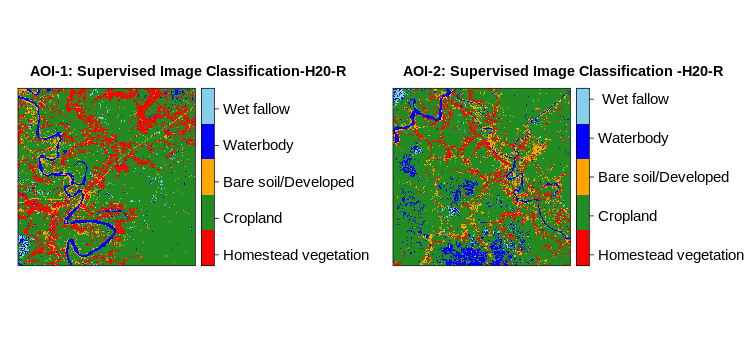

In [36]:
%%R -w 750 -h 350 -u px

# Create color palette
myPalette <- colorRampPalette(c("red","forestgreen","orange", "blue", "sky blue"))
# Plot Map
p1<-spplot(r1,"Class_ID", main="AOI-1: Supervised Image Classification-H20-R" ,
      colorkey = list(space="right",tick.number=1,height=1, width=1.5,
              labels = list(at = seq(0,3.75,length=5),cex=1.25,
              lab = c("Homestead vegetation" ,"Cropland", "Bare soil/Developed ", "Waterbody",  "Wet fallow"))),
              col.regions=myPalette,cut=4)

# Plot Map
p2<-spplot(r2,"Class_ID", main="AOI-2: Supervised Image Classification -H20-R" ,
      colorkey = list(space="right",tick.number=1,height=1, width=1.5,
              labels = list(at = seq(0,4,length=5),cex=1.25,
              lab = c("Homestead vegetation" ,"Cropland", "Bare soil/Developed ", "Waterbody", " Wet fallow"))),
              col.regions=myPalette,cut=4)


grid.arrange(p1, p2, ncol=2)

### Write raster

In [37]:
%%R
writeRaster(r1, filename = "/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/h20_predicted_class_aoi_1.tiff", overwrite=T)
writeRaster(r2, filename = "/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/h20_predicted_class_aoi_2.tiff", overwrite=T)